# Homework 7: Training Logistic Regression via Stochastic Gradient Ascent

In [38]:
import numpy as np
import pandas as pd

### 1. Data preprocessing

In [39]:
products = pd.read_csv('amazon_baby_subset.csv')

Apply text cleaning on the review data

In [40]:
import json
with open('important_words.json', 'r') as f: # Read the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words] # format the data

In [41]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [42]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

In [43]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [44]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Split data into training and validation sets:

In [45]:
with open ('module-10-assignment-train-idx.json') as f:
    train_idx = json.load(f)
with open ('module-10-assignment-validation-idx.json') as f:
    validation_idx = json.load(f) 

In [46]:
train_data = products.iloc[train_idx]
validation_data = products.iloc[validation_idx]

In [47]:
# Convert DataFrames to matrixes that I will use in the model
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return (feature_matrix, label_array)

In [48]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

/Users/shute/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### 2. Building on logistic regression

Derivative of log likelihood with respect to a single coefficient

In [49]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    # Return the derivative
    return derivative

In [50]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1.0 / (1 + np.exp(-1*score))
    
    # return predictions
    return predictions

To track the performance of stochastic gradient ascent, write a function to compute average log likelihood。

In [51]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

#### Modifying the derivative for stochastic gradient ascent.

Computing the gradient for a single data point. The code block below computed the derivative

In [52]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


Modifying the derivative for using a batch of data points.

In [53]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

Gradient mini-batch data points: 1.0
                --> Should print 1.0


Averaging the gradient across a batch

### 3. Implementing stochastic gradient ascent

Implement the logistic regression with stochastic gradient ascent. The function logistic_regression_SG accpet the following parameters:  
feature_matrix: 2D array of features  
sentiment: 1D array of class labels  
initial_coefficients: 1D array containing initial values of coefficients  
step_size: a parameter controlling the size of the gradient steps  
batch_size: size of mini-batch  
max_iter: number of iterations to run stochastic gradient ascent  

* Create an empty list called log_likelihood_all
* Initialize coefficients to initial_coefficients
* Set random seed = 1
* Shuffle the data before starting the loop below
* Set i = 0, the index of current batch

* Run the following steps max_iter times, performing linear scans over the data:
  * Predict P(y_i = +1|x_i,w) using your predict_probability() function
    Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
  * Compute indicator value for (y_i = +1)
    Make sure to slice the i-th entry with [i:i+batch_size]
  * Compute the errors as (indicator - predictions)
  * For each coefficients[j]:
    - Compute the derivative for coefficients[j] and save it to derivative.
      Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
    - Compute the product of the step size, the derivative, and (1./batch_size).
    - Increment coefficients[j] by the product just computed.
  * Compute the average log likelihood over the current batch.
    Add this value to the list log_likelihood_all.
  * Increment i by batch_size, indicating the progress made so far on the data.
  * Check whether we made a complete pass over data by checking
    whether (i+batch_size) exceeds the data size. If so, shuffle the data. If not, do nothing.

* Return the final set of coefficients, along with the list log_likelihood_all.

In [55]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:i+batch_size, :], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = (sentiment[i:i+batch_size] == +1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size, j])
            # Compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            coefficients[j] += (1. / batch_size) * (step_size * derivative)

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size], coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

Note: In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.

Test the above function with the sample data:

In [57]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


Compare. Running gradient ascent using the stochastic gradient ascent implementation

Now run stochastic gradient ascent over the feature_matrix_train for 10 iterations using:  

initial_coefficients = np.zeros(194)  
step_size = 5e-1  
batch_size = 1  
max_iter = 10  

In [58]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients = np.zeros(194),
                                        step_size = 5e-1, batch_size = 1, max_iter = 10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


Now run batch gradient ascent over the feature_matrix_train for 200 iterations using:  

initial_coefficients = np.zeros(194)  
step_size = 5e-1  
batch_size = number of rows in feature_matrix_train  
max_iter = 200  

In [67]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train, 
                                                      initial_coefficients = np.zeros(194), 
                                                      step_size = 5e-1, batch_size = len(feature_matrix_train), 
                                                      max_iter = 200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})


#### Stochastic gradient ascent vs batch gradient ascent

We are comparing:  

stochastic gradient ascent: step_size = 0.1, batch_size=100  
batch gradient ascent: step_size = 0.5, batch_size=[# rows in feature_matrix_train]

Run stochastic gradient ascent for 200 passes using:  
step_size=1e-1  
batch_size=100  
initial_coefficients set to all zeros.  

In [64]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

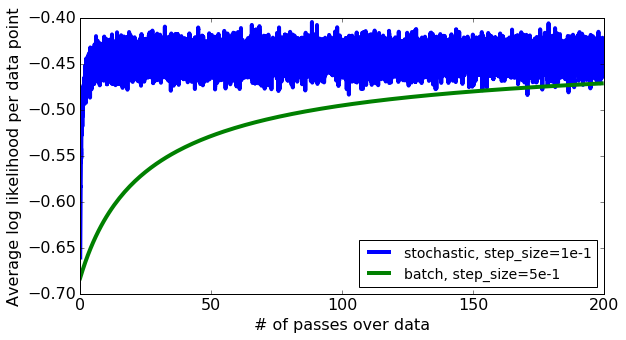

In [68]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

#### Explore the effects of step sizes on stochastic gradient ascent  
Plotting the log likelihood as a function of passes for each step size
step_size = 1e-4  
step_size = 1e-3  
step_size = 1e-2  
step_size = 1e-1  
step_size = 1e0  
step_size = 1e1  
step_size = 1e2  

initial_coefficients=np.zeros(194)  
batch_size=100  
max_iter initialized so as to run 10 passes over the data.  
smoothing_window=30.  


In [70]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

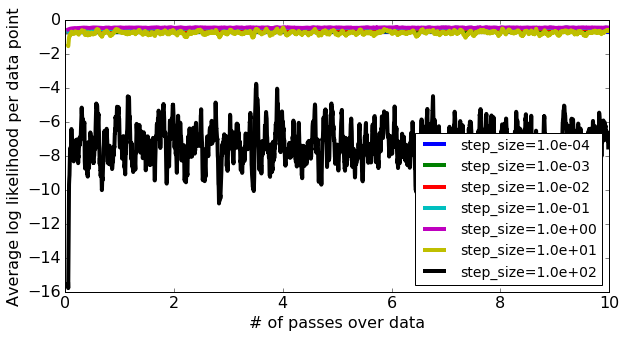

In [71]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)